<a href="https://colab.research.google.com/github/HaydenJF/CPSC392-Project2/blob/main/HW2_SP22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2

## GENERAL INSTRUCTIONS:

- CLEARLY mark where you are answering each question (all questions must be answered in Markdown cells, NOT as comments in code cells)
- Show all code necessary for the analysis, but remove superfluous code
- Check that your final PDF does not have code/markdown cutoff

---

Use the [Loan Dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW2.csv) on GitHub to build the classification models described below.

## Variable Descriptions:
- `age`: age in years of person.
- `had_cancer`: 0 if the person has NOT had cancer or has cancer, 1 if they have.
- `gender_id`: `Male`, `Female`, `Non-Binary`, or `Survey Choices Do Not Accurately Reflect My Identity`.
- `income_in_k`: income in thousands of dollars.
- `state`: state person lives in.
- `credit_score`: credit score.
- `num_credit_sources`: number of sources of credit (includes credit cards, loans, car payments...etc).
- `utilization_rate`: the % of a person's total credit they use on average each month. For example if you have 10,000 dollars in available credit, and use 2,000 your utilization rate would be 0.2 (20%).
- `gave_loan`: whether or not the person got a loan.

## Instructions
1. *Build a KNN, Decision Tree, AND Logistic Regression model to predict whether or not someone got a loan.*
    - If a variable/predictor has more than 2 categories, use `get_dummies()` to convert them into dummy variables (don't forget to remove the original column when training! see [here](https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Extras/get_dummies().ipynb)).
    - use the `train_test_split()` to do an 80/20 split (make sure to use the SAME split when training all 3 models, do not re-split your data. We want each model to be trained on the same training set).
    - Appropriately z-score your continuous variables only (interval data like age...etc can be counted as continuous)
    - For KNN, include only *continuous/interval* columns as predictors. For Decision Tree and Logistic Regression use ALL columns (other than `gave_loan`).
    - For KNN, choose K by using `GridSearchCV`.
    - For Decision Trees, use `GridSearchCV` to choose max_depth, and make sure to check for overfitting.
    - Record the Train/Test accuracies, and print out confusion matrices for both train and test.
    
    
2. *Evaluate Your Models (WRITE YOUR ANSWER IN MARKDOWN CELL)*
    - A) Using accuracy AND confusion matrices, **thoroughly discuss which model did best (if you had to pick one), how can you tell?**
    - B) **Are there differences in how accurate each of the three models you made in part 1 are for different gender IDs?** (do NOT build a new model for this question. This is simply asking whether any of our models are more accurate when applied to different gender groups, regardless of whether gender was used in the model. If it helps, imagine you're about to deploy this model in the real world, and your boss asks whether the model is biased against/for certain gender groups).
    - C) **Are your models better at predicting people who got loans, or didn't get loans? How can you tell? Discuss thoroughly the possible implications of this.**

In [ ]:
#imports
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn import metrics 
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [ ]:
#db setup
db = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/HW2.csv")
print(db)

      age  had_cancer gender_id  income_in_k state  credit_score  \
0      39           0    Female           54    TX           448   
1      43           0    Female           66    NJ           399   
2      42           0      Male           50    NE           509   
3      46           0    Female           79    TX           540   
4      43           0    Female           49    NV           485   
...   ...         ...       ...          ...   ...           ...   
3995   42           0    Female           59    TX           493   
3996   44           0      Male           66    AK           659   
3997   42           0      Male           71    OH           630   
3998   38           0    Female           62    ID           822   
3999   40           0      Male           62    WI           732   

      num_credit_sources  utilization_rate  gave_loan  
0                      4              0.32          0  
1                      4              0.35          0  
2              

## Variable Descriptions:
- `age`: age in years of person.
-- `count`
- `had_cancer`: 0 if the person has NOT had cancer or has cancer, 1 if they have. 
-- `binary`
- `gender_id`: `Male`, `Female`, `Non-Binary`, or `Survey Choices Do Not Accurately Reflect My Identity`. 
-- `cat`
- `income_in_k`: income in thousands of dollars. 
-- `count`
- `state`: state person lives in.
-- `cat`
- `credit_score`: credit score.
-- `count`
- `num_credit_sources`: number of sources of credit (includes credit cards, loans, car payments...etc).
-- `count`
- `utilization_rate`: the % of a person's total credit they use on average each month. For example if you have 10,000 dollars in available credit, and use 2,000 your utilization rate would be 0.2 (20%).
-- `count`
- `gave_loan`: whether or not the person got a loan.
-- `y`

In [ ]:
#dummies: gender_id, state
dummies1 = pd.get_dummies(db["gender_id"])
dummies2 = pd.get_dummies(db["state"])

#all values
X = db[["age",
        "had_cancer",
        "income_in_k", 
        "credit_score", 
        "num_credit_sources", 
        "utilization_rate"]]
X = pd.concat([X,dummies1], axis = 1) 
X = pd.concat([X,dummies2], axis = 1) 

#binary: had_cancer/dummies_gender_id/dummies_state

print(X.head())
print(X.columns)

#continous: age, income_in_k, credit_score, num_credit_sources, utilization_rate
X_continous = ["age",
               "income_in_k", 
               "credit_score", 
               "num_credit_sources", 
               "utilization_rate"]

#y answer
y = db["gave_loan"]

   age  had_cancer  income_in_k  credit_score  num_credit_sources  \
0   39           0           54           448                   4   
1   43           0           66           399                   4   
2   42           0           50           509                   8   
3   46           0           79           540                   6   
4   43           0           49           485                  10   

   utilization_rate  Female  Male  Non-Binary  \
0              0.32       1     0           0   
1              0.35       1     0           0   
2              0.23       0     1           0   
3              0.15       1     0           0   
4              0.20       1     0           0   

   Survey Choices Do Not Accurately Reflect My Identity  ...  SD  TN  TX  UT  \
0                                                  0     ...   0   0   1   0   
1                                                  0     ...   0   0   0   0   
2                                                 

1. *Build a KNN, Decision Tree, AND Logistic Regression model to predict whether or not someone got a loan.*
    - If a variable/predictor has more than 2 categories, use `get_dummies()` to convert them into dummy variables (don't forget to remove the original column when training! see [here](https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Extras/get_dummies().ipynb)).
    - use the `train_test_split()` to do an 80/20 split (make sure to use the SAME split when training all 3 models, do not re-split your data. We want each model to be trained on the same training set).
    - Appropriately z-score your continuous variables only (interval data like age...etc can be counted as continuous)
    - For KNN, include only *continuous/interval* columns as predictors. For Decision Tree and Logistic Regression use ALL columns (other than `gave_loan`).
    - For KNN, choose K by using `GridSearchCV`.
    - For Decision Trees, use `GridSearchCV` to choose max_depth, and make sure to check for overfitting.
    - Record the Train/Test accuracies, and print out confusion matrices for both train and test.

In [ ]:
# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)
# create models
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
lr = LogisticRegression()

In [ ]:
#KNN
X_train_knn = X_train[X_continous]
X_test_knn = X_test[X_continous]
y_train_knn = y_train
y_test_knn = y_test

#get z for pipe
zz = make_column_transformer((StandardScaler(), X_continous))

# make pipe
pipe_knn = make_pipeline(zz, knn)

# choose potential values of k
ks_knn = {"kneighborsclassifier__n_neighbors": range(1,50)}

# use grid search to find best parameters
grid_knn = GridSearchCV(pipe_knn,ks_knn, scoring = "accuracy", cv = 5)

#knn model
knnmod = grid_knn.fit(X_train_knn, y_train_knn)
print(knnmod.best_estimator_.get_params()["kneighborsclassifier__n_neighbors"])

#Decision Tree
X_train_dt = X_train
X_test_dt = X_test
y_train_dt = y_train
y_test_dt = y_test

# make pipe
pipe_dt = make_pipeline(zz, dt)

# choose potential values of k
depths_dt = {"decisiontreeclassifier__max_depth": range(1,12)}

# use grid search to find best parameters
grid_dt = GridSearchCV(pipe_dt,depths_dt, scoring = "accuracy", cv = 5)

#dt model
dtmod = grid_dt.fit(X_train_dt, y_train_dt)
print(dtmod.best_estimator_.get_params()["decisiontreeclassifier__max_depth"])

#Logistic Regression
X_train_lr = X_train
X_test_lr = X_test
y_train_lr = y_train
y_test_lr = y_test
# z
z = StandardScaler()
    
z.fit(X_train_lr[X_continous])


X_train_lr[X_continous] = z.transform(X_train_lr[X_continous])
X_test_lr[X_continous] = z.transform(X_test_lr[X_continous])
# lr model
lrmod = lr.fit(X_train_lr, y_train_lr)

30
3


In [ ]:
#Accuracies
print(knnmod.score(X_test_knn,y_test_knn))
print(dtmod.score(X_test_dt,y_test_dt))
print(lrmod.score(X_test_lr,y_test_lr))

0.755
0.64375
0.75125


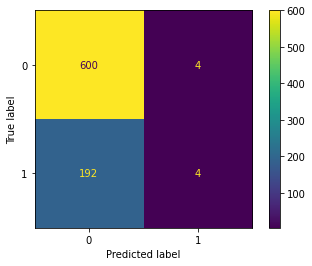

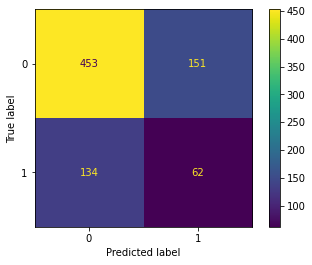

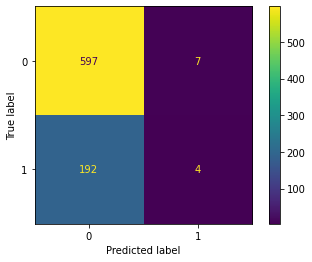

In [ ]:
#Confusion Matrices
plot_confusion_matrix(knnmod, X_test_knn, y_test_knn)
plot_confusion_matrix(dtmod, X_test_dt, y_test_dt)
plot_confusion_matrix(lrmod, X_test_lr, y_test_lr)

2. *Evaluate Your Models (WRITE YOUR ANSWER IN MARKDOWN CELL)*
    - A) Using accuracy AND confusion matrices, **thoroughly discuss which model did best (if you had to pick one), how can you tell?**
    - B) **Are there differences in how accurate each of the three models you made in part 1 are for different gender IDs?** (do NOT build a new model for this question. This is simply asking whether any of our models are more accurate when applied to different gender groups, regardless of whether gender was used in the model. If it helps, imagine you're about to deploy this model in the real world, and your boss asks whether the model is biased against/for certain gender groups).
    - C) **Are your models better at predicting people who got loans, or didn't get loans? How can you tell? Discuss thoroughly the possible implications of this.**

  - A) Using accuracy AND confusion matrices, thoroughly discuss which model did best (if you had to pick one), how can you tell?

I believe the decision tree model is the best for this model for this data.  All the other models seem to be heavily overfitting to the point of mostly just picking 0.  In reality this is worthless because we could have just guessed 0 every time and had a similar score to the two other algorithms. 

I decided against using f1 as the scoring.  It was doing weird stuff with the values (such as getting 0 accuracy with decision tree and .25 accuracy with the knn model).  Although the knn model was much better the decision tree still was worse than the knn model is right now (0 guesses for 1).

  - B) **Are there differences in how accurate each of the three models you made in part 1 are for different gender IDs?** (do NOT build a new model for this question. This is simply asking whether any of our models are more accurate when applied to different gender groups, regardless of whether gender was used in the model. If it helps, imagine you're about to deploy this model in the real world, and your boss asks whether the model is biased towards certain gender groups).

In [ ]:
genders = ["Male", "Female", "Non-Binary", "Survey Choices Do Not Accurately Reflect My Identity"]
model_names = ["knn", "dt", "lr"]
models = [knnmod, dtmod, lrmod]
xtests = [X_test_knn, X_test_dt, X_test_lr]
ytests = [y_test_knn, y_test_dt, y_test_lr]


for j in range(0,3):
  print(model_names[j])
  for i in genders:
    print(i, end = '')
    print(": ", end = '')
    print_model_x = (xtests[j].loc[(X_test[i] == True)])
    print_model_y = (ytests[j].loc[(X_test[i] == True)])
    print(models[j].score(print_model_x, print_model_y))


knn
Male: 0.7520215633423181
Female: 0.7585365853658537
Non-Binary: 0.9
Survey Choices Do Not Accurately Reflect My Identity: 0.5555555555555556
dt
Male: 0.633423180592992
Female: 0.651219512195122
Non-Binary: 0.9
Survey Choices Do Not Accurately Reflect My Identity: 0.4444444444444444
lr
Male: 0.7493261455525606
Female: 0.7536585365853659
Non-Binary: 0.9
Survey Choices Do Not Accurately Reflect My Identity: 0.5555555555555556


For all models it seems that non-binary individuals prediction rate is higher at ~0.9, males and females have an accuracy rate of ~0.75 (~0.65 for decision tree) and other identities accuracy is extremely low at ~0.55 (~0.44 for decision trees).

This is dangerously bad because it our algorithm definitely does have bias towards different gender identities.  For example the decision tree has a twice as likely time accuratly predicting non-binary individuals compared to other non-binary gender identities.  If my boss said he didn't want a bias algorithm I would highly recommend we wouldn't use these.

  - C) **Are your models better at predicting people who got loans, or didn't get loans? How can you tell? Discuss thoroughly the possible implications of this.**

All models were better at figuring out which people didn't get loans than they were at finding out which people did get loans.  We can tell because the percent of 0 guesses that were correct is higher than the percent of 1 guesses that were correct.  Who ever had these models would expect less loans given out than the actual amount loaned.  If a bank was using this model to start given out loans, it would mean that a massive amount of people wouldn't get loans that were qualified.

Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
Ignore this part.
